<img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png">

<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

# Moonshot Strategy

This notebook introduces the Moonshot calendar spread trading strategy code and runs an example backtest. 

## Moonshot strategy code

The calendar spread strategy code is provided in [calspread.py](calspread.py).

### Code highlights

In `prices_to_signals`, we use the function `get_contract_nums_reindexed_like` to isolate the bids and asks of the contract months from which we wish to create the calendar spread:

```python
CONTRACT_NUMS = (1,2)
...

# Get a DataFrame of contract numbers and a Boolean mask of the 
# contract nums constituting the spread
contract_nums = get_contract_nums_reindexed_like(bids, limit=max(self.CONTRACT_NUMS))
are_month_a_contracts = contract_nums == self.CONTRACT_NUMS[0]
are_month_b_contracts = contract_nums == self.CONTRACT_NUMS[1]

# Get a Series of bids and asks for the respective contract months by
# masking with contract num and taking the mean of each row (relying on
# the fact that the mask leaves only one observation per row)
month_a_bids = bids.where(are_month_a_contracts).mean(axis=1)
month_a_asks = asks.where(are_month_a_contracts).mean(axis=1)

month_b_bids = bids.where(are_month_b_contracts).mean(axis=1)
month_b_asks = asks.where(are_month_b_contracts).mean(axis=1)
```

To reflect the fact that we must buy at the ask and sell at the bid, we compute the spread differently for the purpose of identifying long vs short opportunities:
```python
# Buying the spread means buying the month A contract at the ask and
# selling the month B contract at the bid
spreads_for_buys = month_a_asks - month_b_bids

... 

# Selling the spread means selling the month A contract at the bid
# and buying the month B contract at the ask
spreads_for_sells = month_a_bids - month_b_asks
```

In `positions_to_gross_returns`, we model buying at the ask and selling at the bid:
```python
are_buys = positions.diff() > 0
are_sells = positions.diff() < 0
midpoints = (bids + asks) / 2
trade_prices = asks.where(are_buys).fillna(
    bids.where(are_sells)).fillna(midpoints)

gross_returns = trade_prices.pct_change() * positions.shift()
```

### Install strategy file

Install the strategy by moving it to the `/codeload/moonshot` directory:

In [1]:
# make directory if doesn't exist
!mkdir -p /codeload/moonshot

!mv calspread.py /codeload/moonshot/

## Example Backtest

The moonshot file contains an example subclass for backtesting the strategy with CL contract months 1 and 3: 

```python
class CLCalendarSpreadStrategy(CalendarSpreadStrategy):

    CODE = "calspread-cl"
    UNIVERSES = "cl-fut"
    DB = "cl-1h-bbo"
    CONTRACT_NUMS = (1, 3)
    BBAND_LOOKBACK_WINDOW = 60
    BBAND_STD = 2
    COMMISSION_CLASS = NymexCommission
```

Now run the backtest:

In [2]:
from quantrocket.moonshot import backtest
backtest("calspread-cl", filepath_or_buffer="calspread_cl_results.csv")

And view the tear sheet:

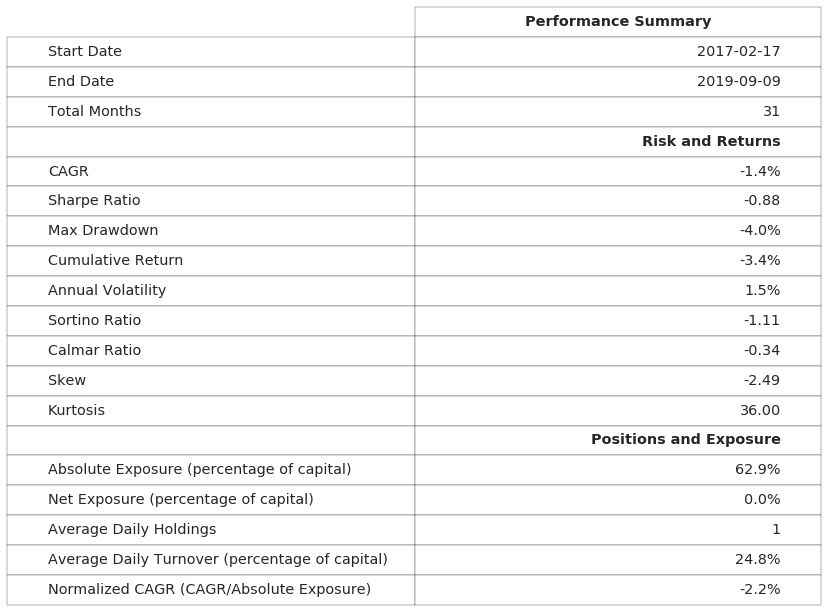

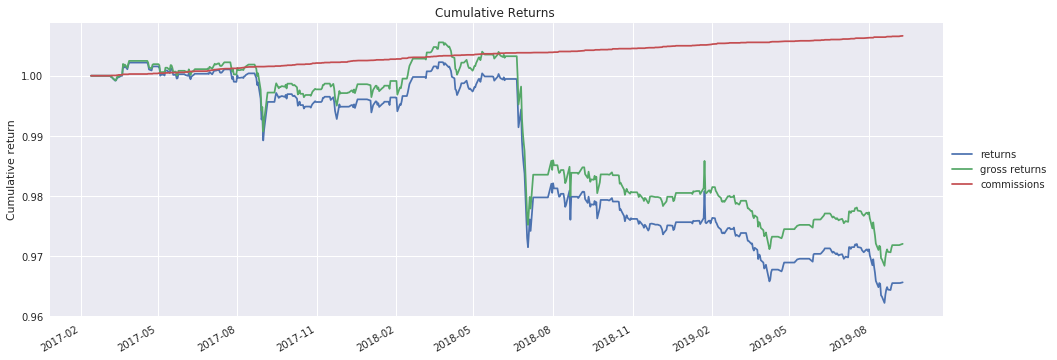

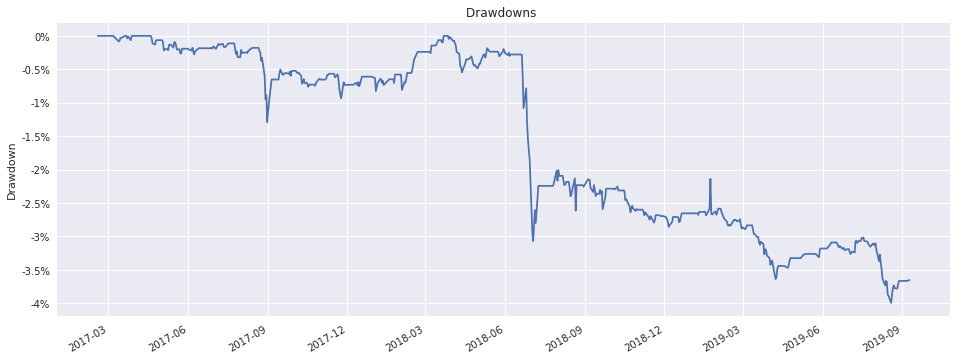

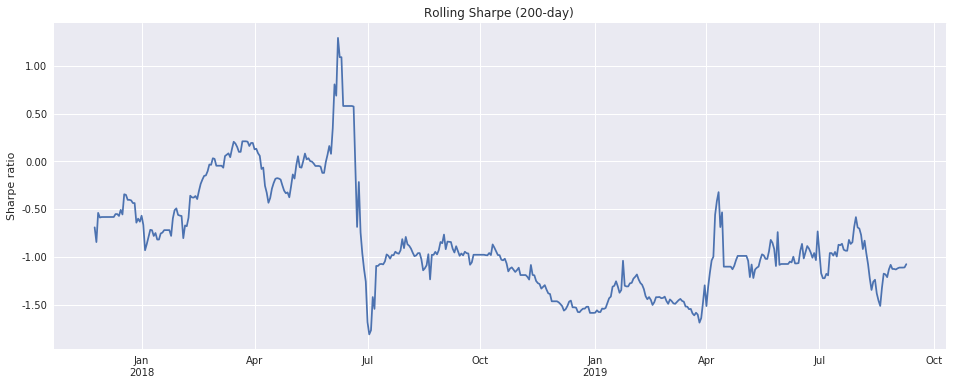

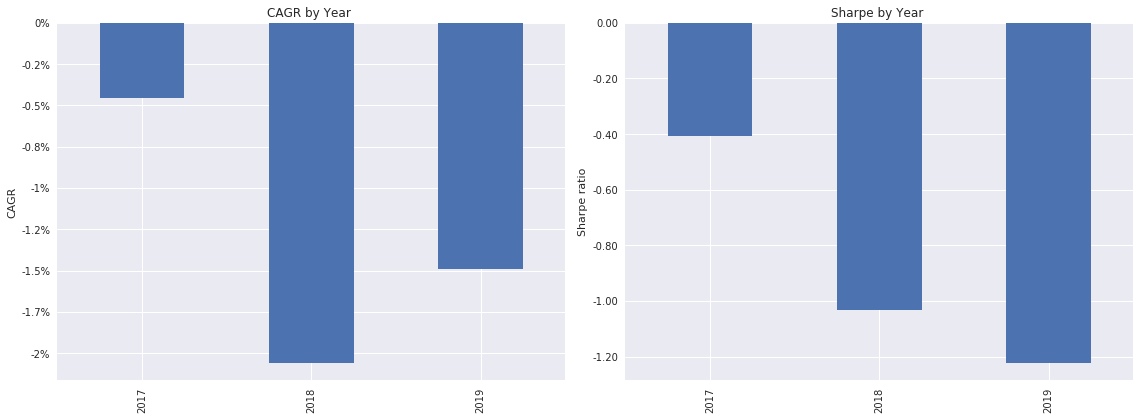

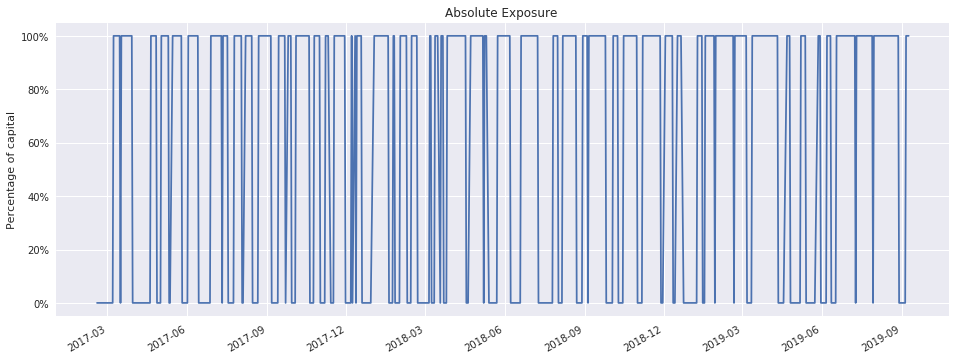

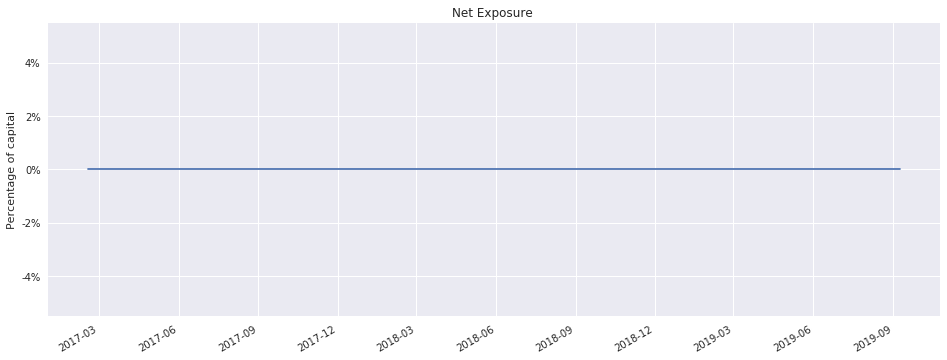

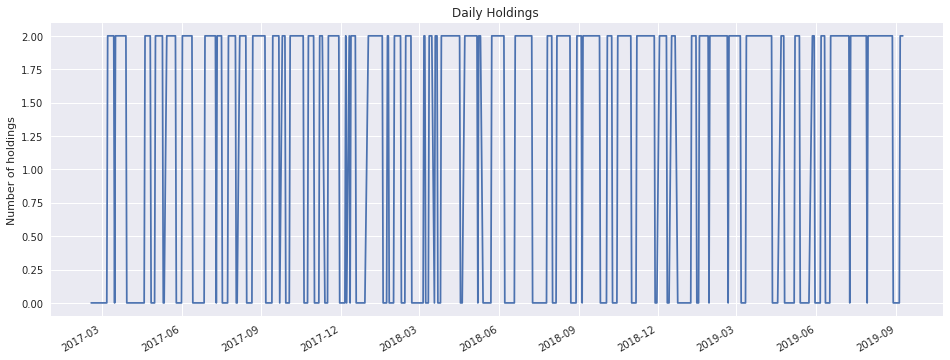

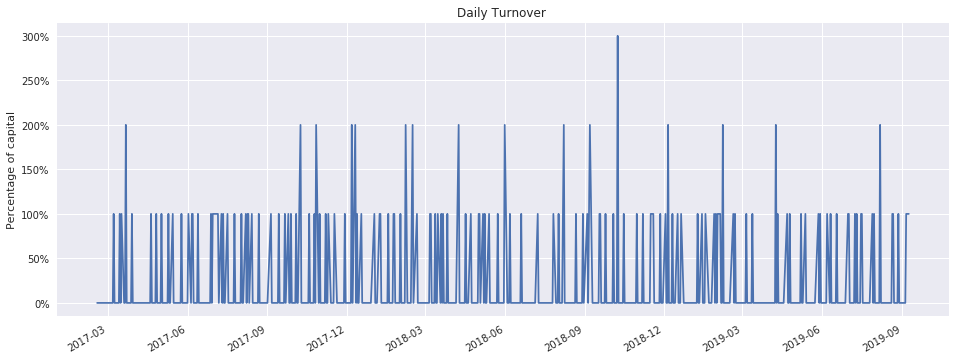

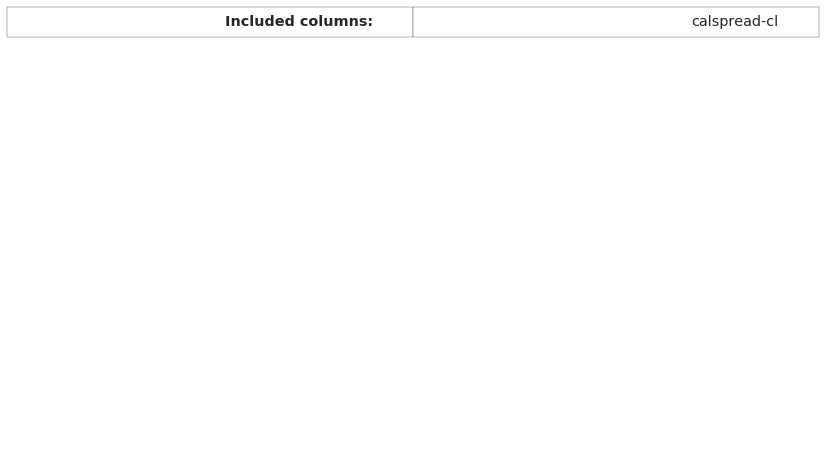

In [3]:
from moonchart import Tearsheet
Tearsheet.from_moonshot_csv("calspread_cl_results.csv")

***

[Back to Introduction](Introduction.ipynb)